### Estimate the noise variance in each data modality

In [1]:
import torch
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


/home/fahimehb/miniconda3/envs/cplae_met/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from cplAE_MET.utils.dataset import MET_exc_inh_v1
from cplAE_MET.utils.load_config import load_config
from cplAE_MET.models.torch_utils import MET_dataset_v1, tonumpy
from cplAE_MET.models.torch_utils import tonumpy


In [3]:
# read input mat file 
paths = load_config(config_file="config.toml", verbose=False)
dat = MET_exc_inh_v1.from_file(paths['MET_data'])
dataset = MET_dataset_v1(dat, device='cpu')
train_ind, val_ind = dat.train_val_split(fold=0, n_folds=10, seed=0)
dataloader = DataLoader(dataset, batch_size=dataset.xt.shape[0], shuffle=False, drop_last=True)
for _, data in enumerate(iter(dataloader)):
    print ("done!")

done!


In [4]:
print("Total number of all the cells: ", data['xt'].shape[0])
print("Total number of cells with T data: ", tonumpy(data['is_t_1d'].sum()))
print("Total number of cells with E data: ", tonumpy(data['is_e_1d'].sum()))
print("Total number of cells with M data: ", tonumpy(data['is_m_1d'].sum()))
print("Total number of cells with M & E data: ", tonumpy(data['is_me_1d'].sum()))
print("Total number of cells with M & T data: ", tonumpy(torch.logical_and(data['is_m_1d'], data['is_t_1d']).sum()))
print("Total number of cells with T & E data: ", tonumpy(torch.logical_and(data['is_e_1d'], data['is_t_1d']).sum()))
print("Total number of cells with M & E & T data: ", tonumpy(torch.logical_and(torch.logical_and(data['is_m_1d'],
                                                             data['is_t_1d']), data['is_e_1d']).sum()))
print("Total number of cells with M data ONLY: ", tonumpy((~data['is_t_1d']).sum()))

Total number of all the cells:  7158
Total number of cells with T data:  6510
Total number of cells with E data:  6356
Total number of cells with M data:  2163
Total number of cells with M & E data:  1915
Total number of cells with M & T data:  1515
Total number of cells with T & E data:  5854
Total number of cells with M & E & T data:  1413
Total number of cells with M data ONLY:  648


In [5]:
#masks for each modality
is_t_1d = data['is_t_1d']
is_e_1d = data['is_e_1d']
is_m_1d = data['is_m_1d']
is_mt_1d = torch.logical_and(is_t_1d, is_m_1d)
is_te_1d = torch.logical_and(is_t_1d, is_e_1d)

In [6]:
# T cells, te cells and mt cells will be used for this analysis. we dont use m-only cells 
# or e-only cells becasue we should groupby types and those that dont have T are not used
xt = pd.DataFrame(tonumpy(data['xt'][is_t_1d]), columns=dat.gene_ids)
xm = pd.DataFrame(tonumpy(data['xm'][is_m_1d]), columns=dat.M_features)
xe = pd.DataFrame(tonumpy(data['xe'][is_e_1d]), columns=dat.E_features)

xte = pd.DataFrame(tonumpy(data['xe'][is_te_1d]), columns=dat.E_features)
xmt = pd.DataFrame(tonumpy(data['xm'][is_mt_1d]), columns=dat.M_features)

xt['cluster_label'] = dat.cluster_label[is_t_1d]
xte['cluster_label'] = dat.cluster_label[is_te_1d]
xmt['cluster_label'] = dat.cluster_label[is_mt_1d]

xt['specimen_id'] = dat.specimen_id[is_t_1d]
xte['specimen_id'] = dat.specimen_id[is_te_1d]
xmt['specimen_id'] = dat.specimen_id[is_mt_1d]

In [7]:
# For m data, i need to put the ax and de to nan for exc cells and
# put api and bas to nan for inhibitory cells. This is becuase the nan
# values are ignore automatically when calculating the variance. If they are
# set to zero, they will be included in averaging 

ax_cols = [c for c in xmt.columns if 'ax' in c]
de_cols = [c for c in xmt.columns if 'de' in c]
api_cols = [c for c in xmt.columns if 'api' in c]
bas_cols = [c for c in xmt.columns if 'bas' in c]

is_ax_1d = (xmt[ax_cols]!=0).all(axis=1)
is_de_1d = (xmt[de_cols]!=0).all(axis=1)
is_api_1d = (xmt[api_cols]!=0).all(axis=1)
is_bas_1d = (xmt[bas_cols]!=0).all(axis=1)

xmt.loc[~is_ax_1d, ax_cols + de_cols] = np.nan
xmt.loc[~is_api_1d, api_cols + bas_cols] = np.nan

In [8]:
xt.groupby("cluster_label").var().mean().mean()

0.20864181220531464

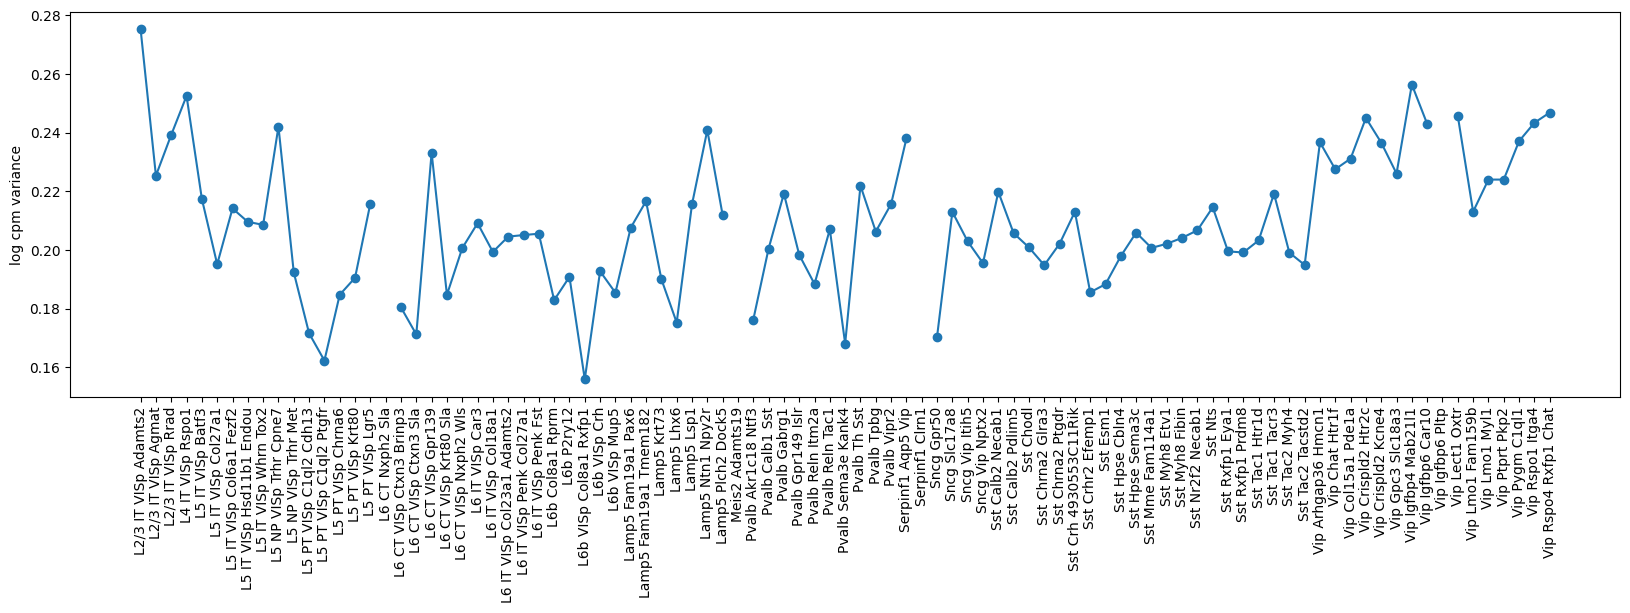

Mean variance: 0.20864181220531464


In [9]:
xt_var_per_type = xt.groupby("cluster_label").var().mean(axis=1)
fig = plt.figure(figsize=(20,5))
plt.plot(xt_var_per_type, 'o-')
plt.xticks(xt_var_per_type.index.to_list(), rotation=90)
plt.ylabel("log cpm variance")
plt.show()
print("Mean variance:", xt.groupby("cluster_label").var().mean().mean())

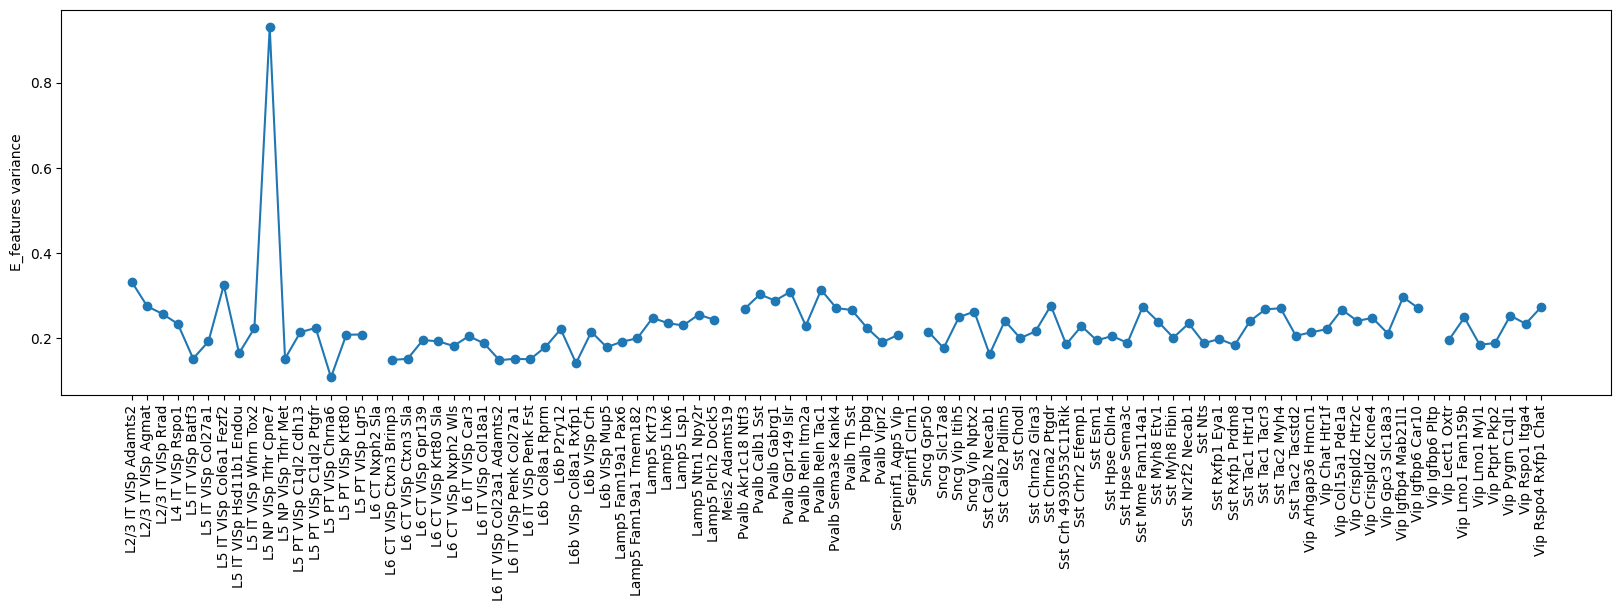

Mean variance: 0.22945010662078857


In [10]:
xe_var_per_type = xte.groupby("cluster_label").var().mean(axis=1)
fig = plt.figure(figsize=(20,5))
plt.plot(xe_var_per_type, 'o-')
plt.xticks(xe_var_per_type.index.to_list(), rotation=90)
plt.ylabel("E_features variance")
plt.show()
print("Mean variance:", xte.groupby("cluster_label").var().mean().mean())

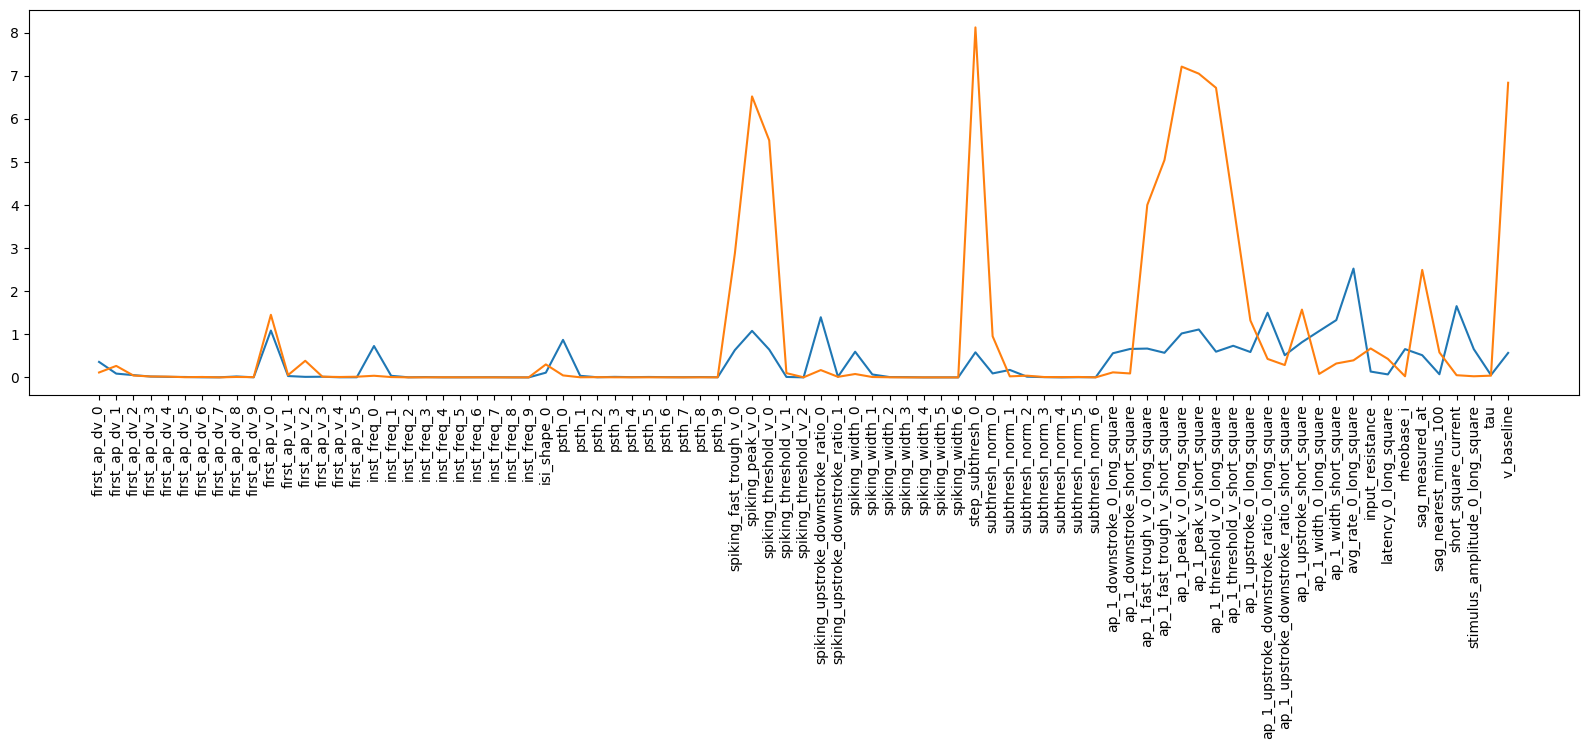

In [11]:
fig = plt.figure(figsize=(20,5))
plt.plot(xte[xte['cluster_label']=="L2/3 IT VISp Adamts2"].drop(columns=["specimen_id", "cluster_label"]).var())
plt.plot(xte[xte['cluster_label']=="L5 NP VISp Trhr Cpne7"].drop(columns=["specimen_id", "cluster_label"]).var())
plt.xticks(rotation=90)
plt.show()

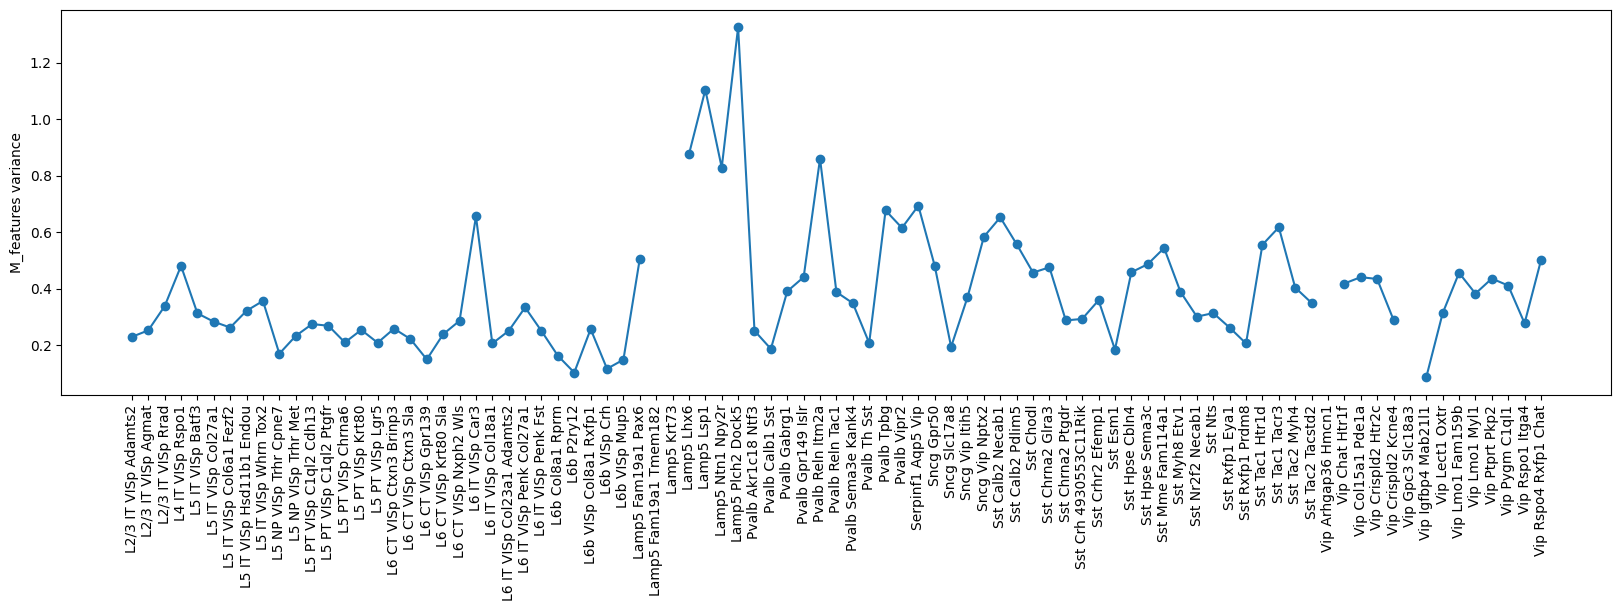

Mean variance: 0.3376249074935913


In [12]:
xm_var_per_type = xmt.groupby("cluster_label").var().mean(axis=1)
fig = plt.figure(figsize=(20,5))
plt.plot(xm_var_per_type, 'o-')
plt.xticks(xm_var_per_type.index.to_list(), rotation=90)
plt.ylabel("M_features variance")
plt.show()
print("Mean variance:", xmt.groupby("cluster_label").var().mean().mean())

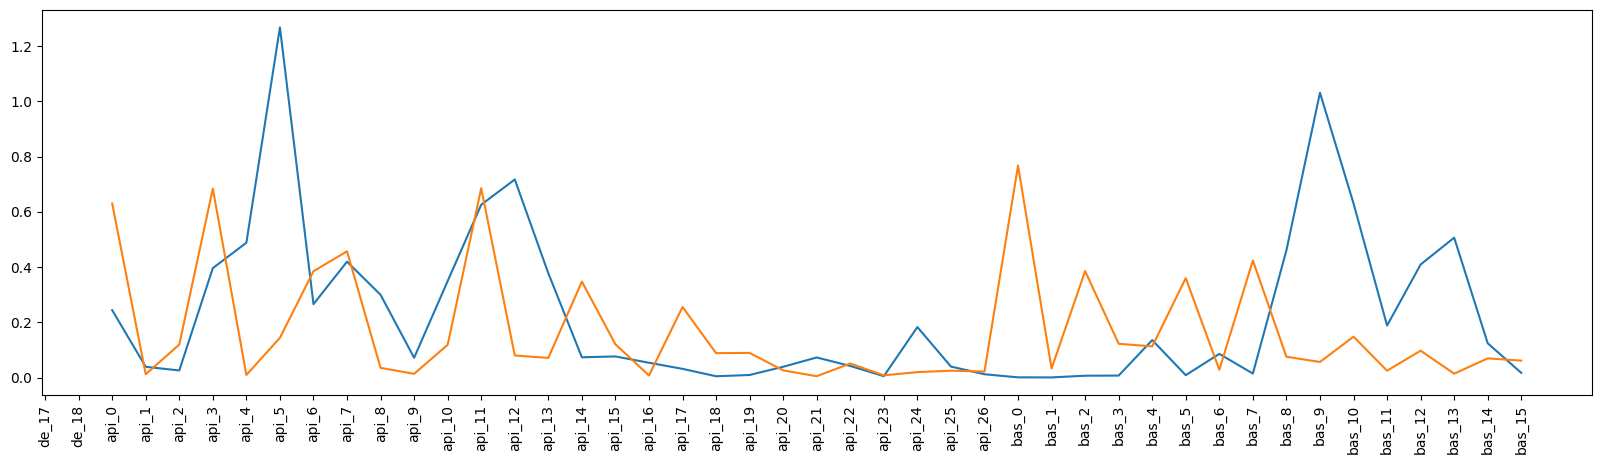

In [13]:
fig = plt.figure(figsize=(20,5))
plt.plot(xmt[xmt['cluster_label']=="L2/3 IT VISp Adamts2"].drop(columns=["specimen_id", "cluster_label"]).var())
plt.plot(xmt[xmt['cluster_label']=="L5 NP VISp Trhr Cpne7"].drop(columns=["specimen_id", "cluster_label"]).var())
plt.xticks(rotation=90)
plt.show()